## Install dependencies

In [ ]:
!pip install transformers 
!pip install datasets 
!pip install evaluate 
!pip install accelerate 
!pip install pillow 
!pip install torchvision 
!pip install scikit-learn

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from datasets import load_dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

## Login to Hugging Face Hub

In [12]:
from huggingface_hub import notebook_login

notebook_login()

### 1. Prepare the dataset

In [18]:
def prepare_data(cards):
    train_data = cards['train']
    test_data = cards['test']
    
    # Extract images and labels
    train_images = train_data['image']
    train_labels = train_data['label']
    test_images = test_data['image']
    test_labels = test_data['label']
    
    # Encode labels
    le = LabelEncoder()
    train_labels_encoded = le.fit_transform(train_labels)
    test_labels_encoded = le.transform(test_labels)
    
    return train_images, train_labels_encoded, test_images, test_labels_encoded, le


### 2. Create a custom dataset class

In [19]:
class MTGDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert RGBA to RGB
        if image.mode == 'RGBA':
            image = Image.new("RGB", image.size, (255, 255, 255))
            image.paste(self.images[idx], mask=self.images[idx].split()[3])

        if self.transform:
            image = self.transform(image)

        return image, label

### 3. Set up model architecture

In [20]:
def get_model(num_classes):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

### 4. Training loop

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")

    return model

In [22]:
def show_images(dataset, label_encoder, num_images=5, images_per_row=2):
    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
    plt.figure(figsize=(images_per_row * 4, rows * 4))
    
    # Randomly pick distinct indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # Change dimensions to HWC for plotting
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        image = image.clip(0, 1)  # Clip values to be between 0 and 1

        ax = plt.subplot(rows, images_per_row, i + 1)
        ax.imshow(image)
        ax.set_title(f"Label: {label_encoder.classes_[label]}", fontsize=10)  # Keep label size the same
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust these values as needed for spacing
    plt.tight_layout()
    plt.show()

# Main execution

In [23]:
# Load the dataset
# cards = load_dataset("acidtib/tcg-magic")
cards = load_dataset("imagefolder", data_dir="datasets/tcg_magic/data")

Resolving data files:   0%|          | 0/8001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/401 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [24]:
# Prepare data
train_images, train_labels, test_images, test_labels, label_encoder = prepare_data(cards)

In [25]:
# Define transforms
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
# Create datasets
train_dataset = MTGDataset(train_images, train_labels, transform=transform)
test_dataset = MTGDataset(test_images, test_labels, transform=transform)

In [27]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

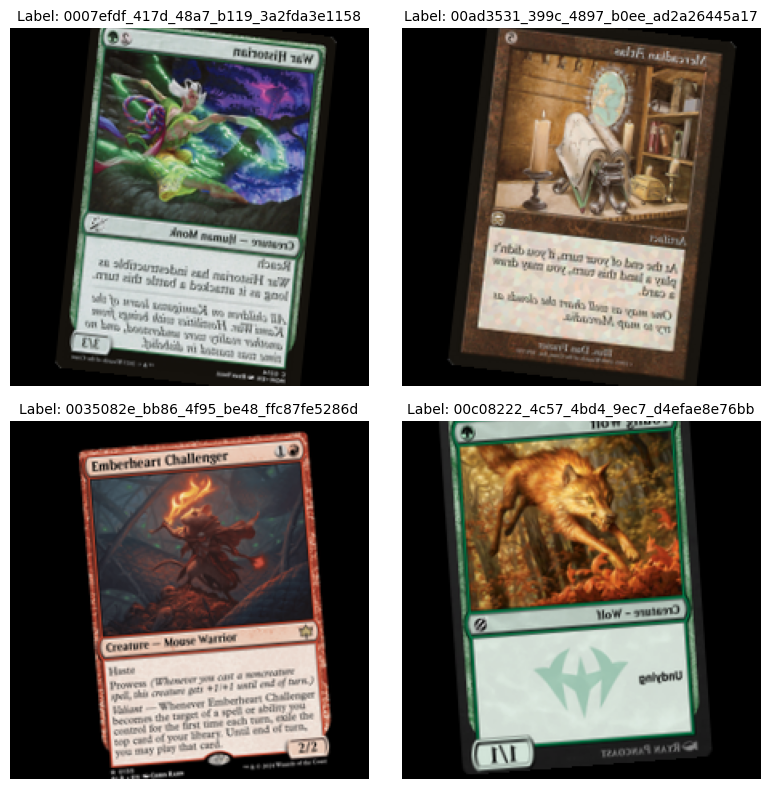

In [28]:
# Show some training images
show_images(train_dataset, label_encoder, num_images=4)

In [29]:
# Initialize model
num_classes = len(label_encoder.classes_)
model = get_model(num_classes)

print("Number of classes:", num_classes)

/home/acid/Code/tcicy/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/acid/Code/tcicy/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of classes: 400


In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [31]:
# Train the model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10: 100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


Epoch 1/10, Loss: 2.7072
Validation Accuracy: 99.50%


Epoch 2/10: 100%|██████████| 250/250 [00:28<00:00,  8.83it/s]


Epoch 2/10, Loss: 0.1282
Validation Accuracy: 100.00%


Epoch 3/10: 100%|██████████| 250/250 [00:27<00:00,  8.97it/s]


Epoch 3/10, Loss: 0.0449
Validation Accuracy: 100.00%


Epoch 4/10: 100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


Epoch 4/10, Loss: 0.0248
Validation Accuracy: 100.00%


Epoch 5/10: 100%|██████████| 250/250 [00:27<00:00,  9.00it/s]


Epoch 5/10, Loss: 0.0166
Validation Accuracy: 100.00%


Epoch 6/10: 100%|██████████| 250/250 [00:28<00:00,  8.86it/s]


Epoch 6/10, Loss: 0.0116
Validation Accuracy: 100.00%


Epoch 7/10: 100%|██████████| 250/250 [00:27<00:00,  8.97it/s]


Epoch 7/10, Loss: 0.0087
Validation Accuracy: 100.00%


Epoch 8/10: 100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


Epoch 8/10, Loss: 0.0069
Validation Accuracy: 100.00%


Epoch 9/10: 100%|██████████| 250/250 [00:28<00:00,  8.76it/s]


Epoch 9/10, Loss: 0.0054
Validation Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 250/250 [00:26<00:00,  9.30it/s]


Epoch 10/10, Loss: 0.0045
Validation Accuracy: 100.00%


In [32]:
# Save the model
torch.save(trained_model.state_dict(), 'mtg_card_classifier.pth')

In [33]:
# Save the label encoder
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']